[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/neurogym/ngym_usage/blob/master/supervised/auto_notebooks/supervised/PerceptualDecisionMaking-v0.ipynb)

# Recurrent Neural Networks

In this tutorial we will learn how to use recurrent neural networks (RNNs) to solve a Perceptual Decision Making task. Here is the index of the tutorial:

- Installs, packages, auxiliary functions.
- Preparing for the training:
    - Training parameters.
    - Define the task (sample dataset).
    - Define the network.
    - Define the algorithm to train the network.
    - Save config.
- Supervised training of the RNN.
- Run the trained network (and save the behavioral data).
- Network analysis:
    - Behavioral analysis.
    - General neural analysis.
    - Stimulus and choice decoding from network activity.

## 0. Installs, packages, auxiliary functions

### 0.1. Install Neurogym

We will use the toolbox [**Neurogym**](https://github.com/neurogym/neurogym/) to define the tasks that our RNNs will have to learn. 

**NeuroGym** is a curated collection of neuroscience tasks with a common interface. It's main goal is to facilitate training of neural network models on neuroscience tasks.

<p align="center">
<img src="https://drive.google.com/uc?export=view&id=1Suk5bvKiFqZCmIu4f1pWNghBxrznJ0U_" alt="drawing" width="1000"/>
</p>

In [111]:
# Uncomment following lines to install
# ! pip install gym   # Install gym
# ! git clone https://github.com/gyyang/neurogym.git  # Install neurogym
# %cd neurogym/
# ! pip install -e .

### 0.2. Imports

Import the packages we need for training and analyzing the RNNs. Especially, we will use the toolbox [pytorch](https://pytorch.org/) to define and train the networks.

In [112]:
# packages to save data
import os
from pathlib import Path
import json

# packages to handle data
import numpy as np
import pandas as pd


# packages to visualize data
import matplotlib.pyplot as plt
import matplotlib as mpl

# import torch and neural network modules to build RNNs
import torch
import torch.nn as nn

# import gym and neurogym to create tasks
import gym
import neurogym as ngym
from neurogym.utils import plotting

# check if GPU is available
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# name of the task on the neurogym library
envid = 'PerceptualDecisionMaking-v0'
# INSTRUCTION 19 (once you have finished the tutorial): Other tasks to try: 'DelayMatchSample-v0', 'GoNogo-v0', 'ContextDecisionMaking-v0'

### 0.3. Auxiliary functions

We need to create a path to save the data from the network that we will analize.

In [113]:
def get_modelpath(envid):
    
    # Make a local file directories
    path = Path('.') / 'files'
    os.makedirs(path, exist_ok=True)
    path = path / envid
    os.makedirs(path, exist_ok=True)
    
    return path

## 1. Preparing for the training

We will first set some parameters for the training.

Then we will focus on the 3 important decisions one has to make before training the network:
- Define the task.
- Define the network.
- Define the algorithm to train the network.

### 1.1. Define the training parameters

We need to define some training parameters:
- *dt*: time step of the task. The task is defined in discrete time steps of 100 ms.
- *lr*: learning rate of the network.
- *n_epochs*: number of epochs to train the network.
- *seq_len*: number of time steps in each trial. The network will be trained on sequences of 100 time steps.
- *batch_size*: number of trials per batch. During training, the network will be trained on batches of trials that contain the inputs to the network and the target outputs (or labels).

Some of these parameters might be more clear later, when we define the task.

In [114]:
# Set up config:
training_kwargs = {'dt': 100,
                   'lr': 1e-2,
                   'n_epochs': 2000,
                   'batch_size': 16,
                   'seq_len': 100,
                   'envid': envid}

### 1.2. Define task

We now define the task parameters:
- *dt*: already defined above.
- *timing*: timing of the different periods of the task: fixation, stimulus, delay, decision.
- *sigma*: standard deviation of the Gaussian noise that will be added to the stimulus.
- *dim_ring*: number of stimuli. Our task will have 2 stimuli and two corresponding choices, i.e. it will be a two-alternative forced choice (2AFC) task. However, the task can be generalized to any number of stimuli and choices.

Once you have your network trained, you can try to change some of these parameters to see how the network performs.

In [115]:
# Set up task parameters
if envid == 'PerceptualDecisionMaking-v0':
    env_kwargs = {'dt': training_kwargs['dt'],
                'timing': {'fixation': 300, 
                            'stimulus': 1000, 
                            'delay': 0, 
                            'decision': 300}, 
                'sigma': 2,                
                'dim_ring': 2}               
else:
    env_kwargs = {'dt': training_kwargs['dt']}

#### 1.2.1. Sample dataset

After having defined how the task (*the environment*) is implemented and which are the training hyperparameters, we now define a function that builds the environment. This function also provides a dataset object, from which we will sample the trials and labels (targets) that will be used to train the network.

In [116]:
def get_dataset(envid, env_kwargs, training_kwargs):
    """
    Create neurogym dataset and environment. 

    args:
        envid (str): name of the task on the neurogym library
        env_kwargs (dict): task parameters
        training_kwargs (dict): training parameters
    
    returns:
        dataset (neurogym.Dataset): dataset object from which we can sample trials and labels
        env (gym.Env): task environment
    """

    # Make supervised dataset using neurogym's Dataset class
    dataset = ngym.Dataset(envid, 
                           env_kwargs=env_kwargs, 
                           batch_size=training_kwargs['batch_size'],
                           seq_len=training_kwargs['seq_len'])
    env = dataset.env
    
    return dataset, env

In [117]:
# call function to sample
dataset, env = get_dataset(envid=envid, env_kwargs=env_kwargs, training_kwargs=training_kwargs)

/home/manuel/anaconda3/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


The *dataset* object provides the inputs and targets to train the RNN. The inputs are the stimuli that the network will receive at each time step. The targets are the labels that the network will have to predict at each time step. In our case, the labels are the choices that the network will have to make at each time step.

In [118]:
inputs, labels = dataset()
print('inputs shape:', inputs.shape)
print('labels shape:', labels.shape)
print('Example inputs:')
print('Fixation     Stimulus Left Stimulus Right')
print(inputs[:20, 0, :])
print('Example labels:')
print(labels[:20, 0])

inputs shape: (100, 16, 3)
labels shape: (100, 16)
Example inputs:
Fixation     Stimulus Left Stimulus Right
[[ 1.          0.          0.        ]
 [ 1.          0.          0.        ]
 [ 1.          0.          0.        ]
 [ 1.         -0.04946501  0.98753864]
 [ 1.          0.6116492   0.5100574 ]
 [ 1.          0.22421557  0.7702077 ]
 [ 1.          0.48964643  0.3471481 ]
 [ 1.          0.33898166  0.54682904]
 [ 1.          0.22888781  0.85198426]
 [ 1.          0.5281368   0.4389877 ]
 [ 1.          0.44669205  0.9593058 ]
 [ 1.          0.29045415  0.7739705 ]
 [ 1.          0.27727622  0.34469274]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 1.          0.          0.        ]
 [ 1.          0.          0.        ]
 [ 1.          0.          0.        ]
 [ 1.          0.17608456  0.4367484 ]]
Example labels:
[0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 0 0 0 0]


As you see, we will train our RNNs with inputs of shape 100 x 16 x 3, corresponding to the lenght of the samples, the batch size and the number of inputs (stimuli). The targets will have shape 100 x 16, corresponding to the lenght of the samples and the batch size.

Let's now plot a few trials for an random agent performing the task. Feel free to run it several times, or explore different agents (random, constant) to get to understand the task.

Text(0.5, 0, 'Time (ms)')

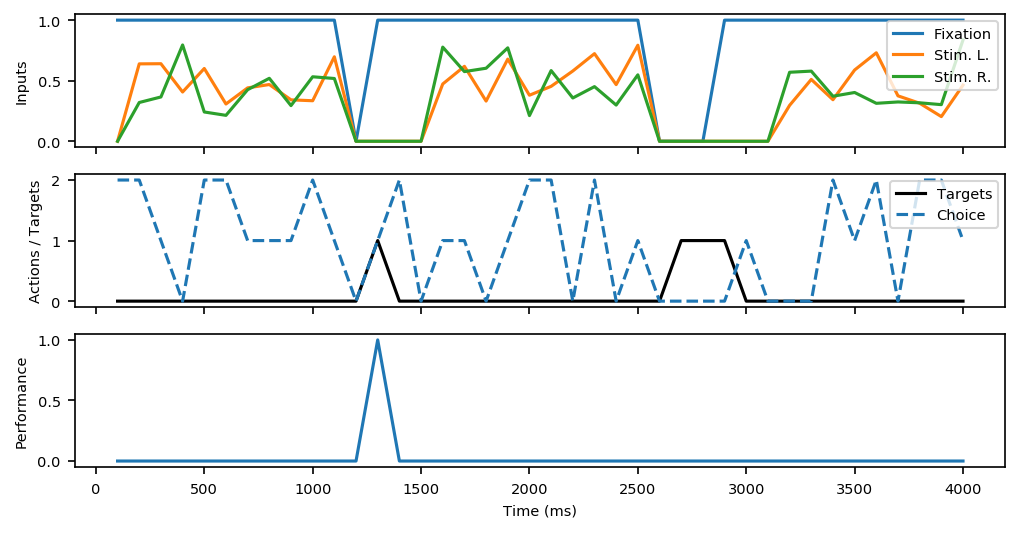

In [119]:
# INSTRUCTION 0. Play with the task (run it several times, try random and constant agents) to see how it works.
mpl.rcParams['font.family'] = ['DejaVu Serif']
num_steps = 40
inputs = []
actions = []
gt = []
perf = []
trial_count = 0
for stp in range(int(num_steps)):
    action = env.action_space.sample()
    # Yoy can also try to set the action to one constant value, e.g. action = 1 
    ob, rew, done, info = env.step(action)
    inputs.append(ob)
    actions.append(action)
    gt.append(info['gt'])
    if info['new_trial']:
        perf.append(info['performance'])
    else:
        perf.append(0)


data = {'ob': np.array(inputs).astype(np.float),
        'actions': actions, 'gt': gt}
# Plot
f, ax = plt.subplots(ncols=1, nrows=3, figsize=(8, 4), dpi=150, sharex=True)

ax[0].plot(np.arange(1, num_steps+1)*env_kwargs['dt'], data['ob'][:, 0], label='Fixation')
ax[0].plot(np.arange(1, num_steps+1)*env_kwargs['dt'], data['ob'][:, 1], label='Stim. L.')
ax[0].plot(np.arange(1, num_steps+1)*env_kwargs['dt'], data['ob'][:, 2], label='Stim. R.')
ax[0].set_ylabel('Inputs')
ax[0].legend()
ax[1].plot(np.arange(1, num_steps+1)*env_kwargs['dt'], data['gt'], label='Targets', color='k')
ax[1].plot(np.arange(1, num_steps+1)*env_kwargs['dt'], data['actions'], label='Choice', linestyle='--')
ax[1].set_ylabel('Actions / Targets')
ax[1].legend()
ax[2].plot(np.arange(1, num_steps+1)*env_kwargs['dt'], perf, label='perf')
ax[2].set_ylabel('Performance')
ax[2].set_xlabel('Time (ms)')

As you can see the inputs (observations) have size 3: two stimuli for the left/right choices (green and orange traces) and one fixation cue (blue trace) that indicates when the network should choose. The goal of the RNN will be to identify which of the two stimuli is larger and to choose the corresponding action.

In the second panel, the target output (ground-truth) is indicated by the dashed green line and the actions in blue come from a random agent. The bottom panel show the performance of the agent (accuracy) at the end of each trial.

### 1.3. Define network

We will now define the network that we want to train. As you have seen in the lecture, RNNs are defined by a set of units that are connected to each other. 



<p align="center">
<img src="https://drive.google.com/uc?export=view&id=1ENHA_qKp3Cl_D0qagUMAJTLHKdJpA1nb" alt="drawing" width="1000"/>
</p>


RNNs can receive an input (x) that changes from timestep to timestep and produce an associated output (y). The activity of their units at any timestep ($h_t$) is passed to the network as an extra input in the next timestep ($h_{t+1}$). 

The connections between the different units will be defined by a matrix of weights ($W_R$) that is initialized with random values.

Then, we need to define the transfer function of the units ($g_h$). We will use rectified linear units which just take the positive part of the input.

Finally, we will readout the units activity with a linear projection to the output units ($g_y$).

Let's first define the parameters of the network:
- the number (*dimensionality*) of inputs.
- the number of hidden units (neurons) in the network.
- the dimensionality of outputs.

In [120]:
# Set up config:
num_neurons = 64

net_kwargs = {'hidden_size': num_neurons,
              'action_size': env.action_space.n,
              'input_size': env.observation_space.shape[0]} # size of the input to the network

In the following, we define a `Net` class, which creates our network from standard modules in `pytorch`. As you know from previous tutorials, classes can have associated methods, which are functions specified uniquely for object of the respective class. Our Net class will have:
- An `_init_` method that will be run when a new object is created and defines the network architecture.
- A `forward` method, that receives the input and returns the output of the network (taking into account the network's architecture).

In [121]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Net, self).__init__()
        
        # INSTRUCTION 1: build a recurrent neural network with a single recurrent layer and rectified linear units
        self.vanilla = nn.RNN(input_size, hidden_size, nonlinearity='relu')
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # INSTRUCTION 2: get the output of the network for a given input
        out, _ = self.vanilla(x)
        x = self.linear(out)
        return x, out

We will now create an *instance* of the `Net` class with the desired hyperparameters as defined above. We will then pass this network to our GPU for training.

In [122]:
# Define network instance from the Net class
net = Net(input_size=env.observation_space.shape[0],
          hidden_size=net_kwargs['hidden_size'],
          output_size=env.action_space.n)

# Move network to the device (CPU or GPU)
net = net.to(device)

### 1.4. Define the algorithm to train the network



To teach the network to perform the task, we will use a supervised learning approach. This means that we will provide the network with the inputs and the target outputs (or labels) and we will train the network to predict the target outputs from the inputs. For that we need a loss function that quantifies the difference between the network's predictions and the target outputs. Here's a screenshot of this morning presentation for you to remember how we train a network using gradient descent on a loss function. 

<p align="center">
<img src="https://drive.google.com/uc?export=view&id=1cJjCcgc3jgdrsd2nq0AsDq628nK0eUZA" alt="drawing" width="600"/>
</p>

We will use the cross-entropy loss function, which is commonly used for classification tasks (here the network has to classify the stimuli into two categories). The cross-entropy loss function is defined as:

$$L = - \sum_{i=1}^{N} y_i \log(\hat{y}_i)$$

where L is the loss, $N$ is the number of samples, $y_i$ is the target output and $\hat{y}_i$ is the network's prediction for the $i$-th sample.

We will also define the optimizer that will be used to train the network. We will use Adam, which is a popular optimizer commonly used in deep learning.

In [123]:
# Define loss: instance of the CrossEntropyLoss class
criterion = nn.CrossEntropyLoss()

# Define optimizer
optimizer = torch.optim.Adam(net.parameters(), lr=training_kwargs['lr'])

### 1.5. Save config

In [124]:
training_kwargs['env_kwargs'] = env_kwargs
training_kwargs['net_kwargs'] = net_kwargs

# Save config
with open(get_modelpath(envid) / 'config.json', 'w') as f:
    json.dump(training_kwargs, f)

## 2. Supervised training of the RNN

In [125]:
print('Training task ', envid)

num_epochs = training_kwargs['n_epochs']

# We'll keep track of the loss as we train. 
# It is initialized to zero and then monitored over training interations
running_loss = 0.0 

for i in range(num_epochs):
    
    # get inputs and labels and pass them to the GPU
    inputs, labels = dataset()
    inputs = torch.from_numpy(inputs).type(torch.float).to(device)
    labels = torch.from_numpy(labels.flatten()).type(torch.long).to(device)
    # print shapes of inputs and labels
    if i == 0:
        print('inputs shape: ', inputs.shape)
        print('labels shape: ', labels.shape)
        print('Max labels: ', labels.max())
    # we need zero the parameter gradients to re-initialize and avoid they accumulate across epochs
    optimizer.zero_grad()

    # INSTRUCTION 3: FORWARD PASS: get the output of the network for a given input
    outputs, _ = net(inputs)

    #reshape outputs so they have the same shape as labels
    outputs = outputs.view(-1, env.action_space.n)

    #  INSTRUCTION 4: compute loss with respect to the labels
    loss = criterion(outputs, labels)
    
    # INSTRUCTION 5: compute gradients
    loss.backward()
    
    # INSTRUCTION 6: update weights
    optimizer.step()

    # print average loss over last 200 training iterations and save the current network
    running_loss += loss.item()
    if i % 200 == 199:
        print('{:d} loss: {:0.5f}'.format(i + 1, running_loss / 200))
        running_loss = 0.0
        
        # save current state of network's parameters
        torch.save(net.state_dict(), get_modelpath(envid) / 'net.pth')

print('Finished Training')

Training task  PerceptualDecisionMaking-v0
inputs shape:  torch.Size([100, 16, 3])
labels shape:  torch.Size([1600])
Max labels:  tensor(2)
200 loss: 0.17838
400 loss: 0.09527
600 loss: 0.07132
800 loss: 0.07132
1000 loss: 0.06786
1200 loss: 0.06707
1400 loss: 0.06671
1600 loss: 0.06633
1800 loss: 0.06756
2000 loss: 0.06690
Finished Training


## 3. Run the trained network
### (and save the behavioral data)

We will now run the network that we have trained. Importantly, we will record the activity of the network and the task variables for the analysis.

In [126]:
# load configuration file - we might have run the training on the cloud and might now open the results locally
with open(get_modelpath(envid) / 'config.json') as f:
    config = json.load(f)

First, we will reconstruct the environment from our config file.

In [127]:
# Environment
env = gym.make(envid, **config['env_kwargs'])
try:
    env.timing = config['env_kwargs']['timing']
except KeyError:
    timing = {}
    for period in env.timing.keys():
        period_times = [env.sample_time(period) for _ in range(100)]
        timing[period] = np.median(period_times)
    env.timing = timing
env.reset(no_step=True) # this is to initialize the environment 

/home/manuel/anaconda3/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


array([-0.6958553, -1.1253039, -1.1020434], dtype=float32)

Now, we'll make a new instance of the `Net` class and populate it with hyperparameters from our config file, as well as the trained weights.

In [128]:
# Since we will not train the network anymore, we can turn off the gradient computation. The most commun way to do this is to use the context manager torch.no_grad() as follows:
with torch.no_grad():
    net = Net(input_size=config['net_kwargs']['input_size'],
              hidden_size=config['net_kwargs']['hidden_size'],
              output_size=config['net_kwargs']['action_size'])
    
    net = net.to(device) # pass to GPU for running forwards steps
    
    # load the trained network's weights from the saved file
    net.load_state_dict(torch.load(get_modelpath(envid) / 'net.pth'))

    # how many trials to run
    num_trial = 1000
    
    # empty lists / dataframe to store activity, choices, and trial information
    activity = list()
    obs = list()
    info = pd.DataFrame()
    
    for i in range(num_trial):

        # create new trial
        env.new_trial()
        
        # read out the inputs in that trial
        inputs = torch.from_numpy(env.ob[:, np.newaxis, :]).type(torch.float)
        # as before you can print the shapes of the variables to understand what they are and how to use them
        # do this for the rest of the variables as you build the code
        if i == 0:
            print('Shape of inputs: ' + str(inputs.shape))
        # INSTRUCTION 7: get the network's prediction for the current input
        action_pred, hidden = net(inputs)
        action_pred = action_pred.numpy()
        
        # INSTRUCTION 8: get the network's choice. 
        # Take into account the shape of action_pred. Remember that the network makes a prediction for each time step in the trial.
        # Which is the prediction we really care about when evaluating the network's performance?
        choice = np.argmax(action_pred[-1, 0, :])
        
        # INSTRUCTION 9: check if the choice is correct
        # Again, which is the target we want when evaluating the network's performance?
        correct = choice == env.gt[-1]

        # Log trial info
        trial_info = env.trial
        trial_info.update({'correct': correct, 'choice': choice}) # write choices and outcome
        info = info.append(trial_info, ignore_index=True)
        
        # Log activity
        activity.append(np.array(hidden)[:, 0, :])
        
        # Log the inputs (or observations) received by the network
        obs.append(env.ob)

    print('Average performance', np.mean(info['correct']))

activity = np.array(activity)
obs = np.array(obs)

# print stats of the activity: max, min, mean, std
print('Activity stats:')
print('Max: ' + str(np.max(activity)) + \
      ', Min: ' + str(np.min(activity)) + \
      ', Mean: ' + str(np.mean(activity)) + \
      ', Std: ' + str(np.std(activity)) + \
        ', Shape: ' + str(activity.shape))

Shape of inputs: torch.Size([16, 1, 3])
Average performance 0.818
Activity stats:
Max: 7.980651, Min: 0.0, Mean: 0.114526235, Std: 0.37704355, Shape: (1000, 16, 64)


### 4. Network analysis

#### 4.1. Behavioral analysis

First, we will do a simple analysis of the network's behavior. Will the network behave similarly to a human participant? We have seen above that its average fraction of correct is at ~ 0.8-0.9. Let's now calculate the psychometric curve, i.e., performance by evidence levels. Use the `info` dataframe as if it was behavioral data from a participant.

In [129]:
# print the variables in the info dataframe
print('Info dataframe:')
print(info.head())

Info dataframe:
   choice   coh  correct  ground_truth
0     2.0   6.4      1.0           1.0
1     2.0  25.6      1.0           1.0
2     1.0  12.8      1.0           0.0
3     2.0   0.0      0.0           0.0
4     2.0   0.0      0.0           0.0


Plot the psychometric curve. You can use the function you wrote in the first tutorial.

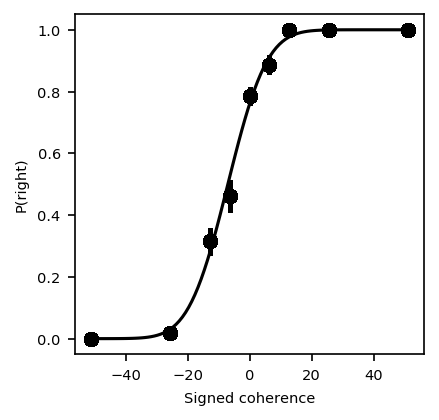

In [130]:
# plot the probability of choosing right as a function of the signed coherence and then fit a psychometric curve to the data.
mpl.rcParams['font.family'] = ['DejaVu Serif']
from scipy.optimize import curve_fit
from scipy.special import erf
def probit(x, beta, alpha):
    """
    Return probit function with parameters alpha and beta.

    Parameters
    ----------
    x : float
        independent variable.
    beta : float
        sensitiviy.
    alpha : TYPE
        bias term.

    Returns
    -------
    probit : float
        probit value for the given x, beta and alpha.

    """
    probit = 1/2*(1+erf((beta*x+alpha)/np.sqrt(2)))
    return probit

f, ax = plt.subplots(1, 1, figsize=(3, 3), dpi=150)
choice = info['choice'].values
# translate choice to 0 and 1
choice_01 = np.copy(choice)
choice_01 -= 1
gt = info['ground_truth'].values
coherence = info['coh'].values
# get signed coherence
signed_coherence = np.copy(coherence)
signed_coherence[gt == 0] = -signed_coherence[gt == 0]
# INSTRUCTION 10: plot the probability of choosing right as a function of the signed coherence
for sc in np.unique(signed_coherence):
    prob_right = np.mean(choice_01[signed_coherence == sc])
    std_right = np.std(choice_01[signed_coherence == sc])/np.sqrt(np.sum(signed_coherence == sc))
    ax.errorbar(sc, prob_right, yerr=std_right, color='k')
    ax.plot(sc, prob_right, 'o', color='k')
    ax.set_xlabel('Signed coherence')
    ax.set_ylabel('P(right)')
# fit psychometric curve
pars, _ = curve_fit(probit, signed_coherence, choice_01, p0=[0, 1])
x = np.linspace(-50, 50, 100)
ax.plot(x, probit(x, *pars), color='k')
plt.show()

#### 4.2. neural analysis

We will now inspect the network actity and observations. `activity` is of shape (100, 24, 64) (`[ntrials x ntime x nneurons]`), and observations of shape (100, 24, 3) (`[ntrials x ntime x nobs]`). 

##### Plot an example trial

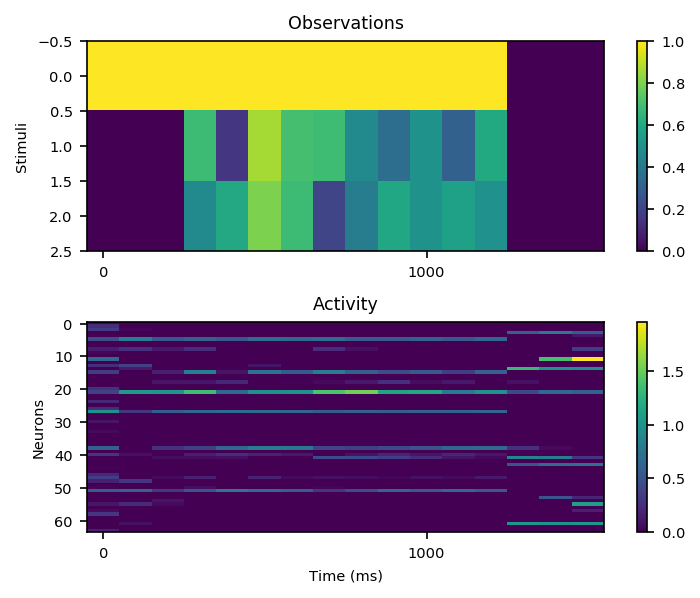

In [131]:
def plot_activity(activity, obs, config, trial):

    # Load and preprocess results
    f, ax = plt.subplots(figsize=(5, 4), nrows=2, dpi=150)

    # time in ms
    t_plot = np.arange(activity.shape[1]) * config['dt']

    # plot the observations for one trial. Note that we will visualize the inputs as a matrix instead of traces, as we have done before.
    im = ax[0].imshow(obs[trial].T, aspect='auto', vmin=0, vmax=1)
    ax[0].set_title('Observations')
    ax[0].set_ylabel('Stimuli')

    # change the xticks to show time in ms
    ax[0].set_xticks(np.arange(0, activity.shape[1], 10))
    ax[0].set_xticklabels(t_plot[::10])
    plt.colorbar(im, ax=ax[0])
    # INSTRUCTION 11: plot the activity for one trial
    im = ax[1].imshow(activity[trial].T, aspect='auto', cmap='viridis')
    ax[1].set_title('Activity')
    ax[1].set_xlabel('Time (ms)')
    ax[1].set_ylabel('Neurons')
    plt.colorbar(im, ax=ax[1])
    # change the xticks to show time in ms
    ax[1].set_xticks(np.arange(0, activity.shape[1], 10))
    ax[1].set_xticklabels(t_plot[::10])

    plt.tight_layout()

plot_activity(activity=activity, obs=obs, config=config, trial=0)

You can see that many neurons are completely silent. Is this always like this? Let's identify and exclude the silent neurons.

fraction of silent neurons: 0.390625


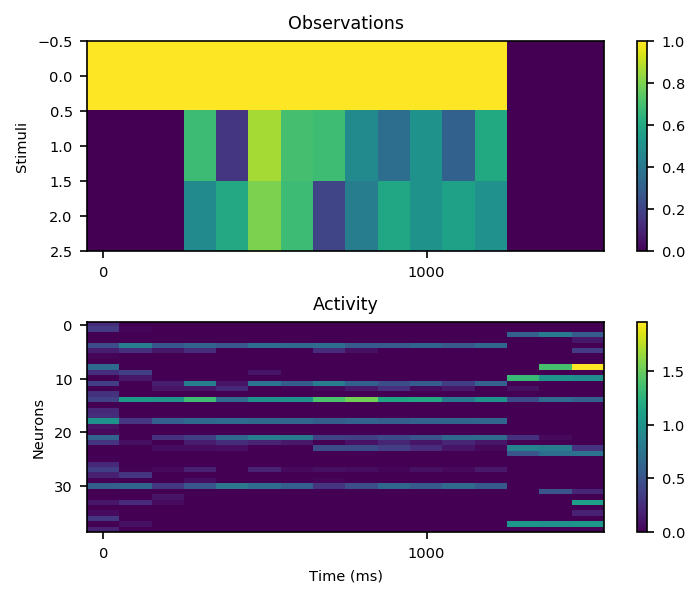

In [132]:
silent_idx = np.where(activity.sum(axis=(0, 1))==0)[0]

print('fraction of silent neurons:', len(silent_idx)/activity.shape[-1])
# INSRTUCTION 12: plot the activity for one trial, but now excluding the silent neurons
clean_activity = activity[:,:,np.delete(np.arange(activity.shape[-1]), silent_idx)]
plot_activity(activity=clean_activity, obs=obs, config=config, trial=0)

 You see that 50% of the neurons are silent. Why do you think this happens?
 
 Also, as in biological networks, the active units of the RNN have different levels of activity. We will thus normalize the acitvity across all trials (so that all neurons have the same minimum and maximum activity) and plot again.

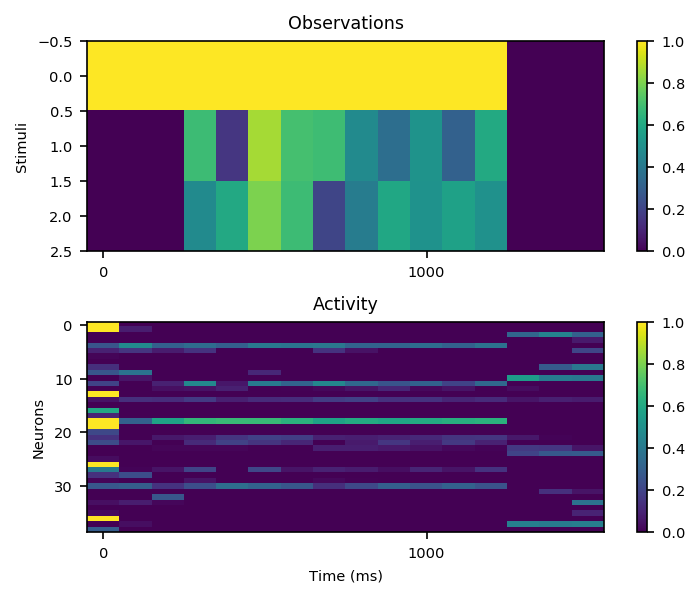

In [133]:
# min_max scaling
minmax_activity = np.array([neuron-neuron.min() for neuron in clean_activity.transpose(2,0,1)]).transpose(1,2,0)
minmax_activity = np.array([neuron/neuron.max() for neuron in minmax_activity.transpose(2,0,1)]).transpose(1,2,0)

plot_activity(activity=minmax_activity, obs=obs, config=config, trial=0)

We can see that neurons have mixed activtity profiles, corresponding to the different task periods. Can you figure out the role played by some of these neurons?

#### Plot Peristimulus histograms for the different choices

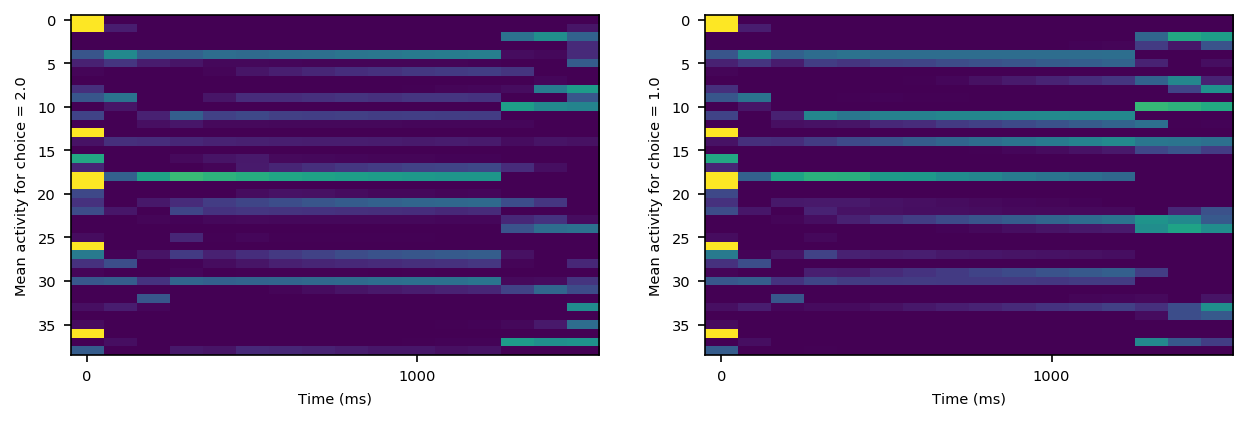

In [134]:
def analysis_activity_by_condition(activity, info, config, conditions=['choice']):
    """
    Plot single neuron activity by condition.
    """   
    for condition in conditions:
        values = pd.unique(info[condition])
        f, ax = plt.subplots(figsize=(10, 3), ncols=len(values), sharex=True, dpi=150)
        t_plot = np.arange(activity.shape[1]) * config['dt']
        for i_v, value in enumerate(values):
            # INSTRUCTION 13: plot the average activity across neurons and trials for each condition
            a = activity[info[condition] == value]
            ax[i_v].imshow(a.mean(axis=0).T, aspect='auto', cmap='viridis')
            ax[i_v].set_xlabel('Time (ms)')
            ax[i_v].set_ylabel('Mean activity for ' + condition + ' = ' + str(value))
            # change the xticks to show time in ms
            ax[1].set_xticks(np.arange(0, activity.shape[1], 10))
            ax[1].set_xticklabels(t_plot[::10])

        # plt.legend(title=condition, loc='center left', bbox_to_anchor=(1.0, 0.5))

analysis_activity_by_condition(minmax_activity, info, config, conditions=['choice']) # other conditions: correct, ground_truth

As you can see, there are neurons that are more active for one choice than for the other. And others are active for both, what do you think they are doing?

### 4.3. Stimulus and choice decoding from hidden unit activity

We will now look at the information content in the hidden layers: How long does it take (after stimulus presentation) until the RNN represents stimuli reliably? We are going to use linear discriminant analysis (`sklda.LinearDiscriminantAnalysis`), which is a simple linear classifier. 

For each time bin, we will divide the `ntrials x nneurons` activity matrix, as well as the `ntrials` vector of labels (`info.ground_truth.values`) into a train and test set by calling `sklms.train_test_split()`. We will then fit LDA weights on the train set, and predict labels (left vs. right) from the test set activity to calculate the classification accuracy. 

Repeat that procedure for 100 train-test-splits to calculate the mean classification accuracy for each timepoint, as well as 95% confidence intervals over train-test-splits.

In [135]:
import sklearn.model_selection as sklms
import sklearn.discriminant_analysis as sklda

In [136]:
# number of CV splits
n_splits = 100

# set
mean_acc = np.zeros([n_splits, minmax_activity.shape[1]]) * np.nan

for i in range(n_splits):    
    
    # transpose tensor to be shape [trials, time, neurons]
    for xi,x in enumerate(minmax_activity.transpose(1,0,2)):

        # INSTRUCTION 14: split data into train and test sets using sklms.
        x_train, x_test, y_train, y_test = sklms.train_test_split(x, info.ground_truth.values, random_state=i)

        # INSTRUCTION 15: fit a linear discriminant analysis model to the training data using sklda
        lda_fitted = sklda.LinearDiscriminantAnalysis(solver='lsqr').fit(X=x_train, y=y_train)

        # INSTRUCTION 16: predict the labels for the test data
        y_pred = lda_fitted.predict(x_test)

        # INSTRUCTION 17: compute the accuracy of the model
        correct = 1 - np.abs(y_pred - y_test)

        mean_acc[i,xi] = correct.mean()

In [137]:
# calculate 95% CI
ci_acc = np.percentile(mean_acc, [5,95], axis=0)

Plot the classification accuracy (together with the 95% CI) over the course of time.

(0, 1500)

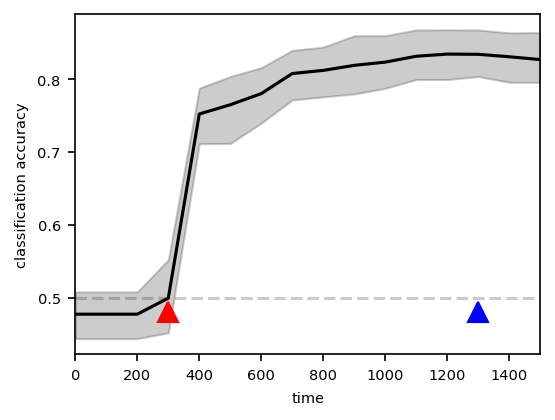

In [138]:
# for plotting: time axis, stim and resp times
t_plot = np.arange(activity.shape[1]) * config['dt']
stim_onset = t_plot[np.where(obs[0,:,1]!=0)[0][0]]
resp_onset= t_plot[np.where(obs[0,:,0]!=1)[0][0]]

# plot linear classification accuracy
plt.figure(figsize=(4,3), dpi=150)
plt.plot(t_plot, np.zeros(mean_acc.shape[1])+.5, 'k--', alpha=.2)
plt.plot(stim_onset, .48, '^', color = 'r', ms=10)
plt.plot(resp_onset, .48, '^', color='b', ms=10)
plt.plot(t_plot, np.mean(mean_acc, axis=0), 'k')
plt.fill_between(t_plot, ci_acc[0], ci_acc[1], color='k', alpha=.2)
plt.ylabel('classification accuracy')
plt.xlabel('time')
plt.xlim(t_plot[0],t_plot[-1])

We can see that before stimulus presentation, classification accuracy is at chance. In contrast, information about the stimulus rises quickly after. 

Will these network dynamics look different for stimuli of different coherence levels? Repeat the same analysis for each level of coherence (`info.coh.values`) and plot the mean accuracy with the pre-specified color gradient. To keep the plot clean, skip confidence intervals.

In [139]:
mean_acc = np.zeros([len(np.unique(info.coh.values)), n_splits, minmax_activity.shape[1]])

for ci,c in enumerate(np.unique(info.coh.values)):
    
    # INSTRUCTION 18: get the indices of the trials with the current coherence
    cidx = np.where(info.coh.values==c)
    
    for i in range(n_splits):    

        # transpose tensor to be shape [trials, time, neurons]
        for xi,x in enumerate(minmax_activity[cidx].transpose(1,0,2)):

            # train-test-split
            x_train, x_test, y_train, y_test = sklms.train_test_split(x, info.ground_truth.values[cidx], random_state=i)

            # fit to train data
            lda_fitted = sklda.LinearDiscriminantAnalysis(solver='lsqr').fit(X=x_train, y=y_train)

            # predict test set labels
            y_pred = lda_fitted.predict(x_test)

            # is the response correct for each trial?
            correct = 1 - np.abs(y_pred - y_test)

            mean_acc[ci,i,xi] = correct.mean()

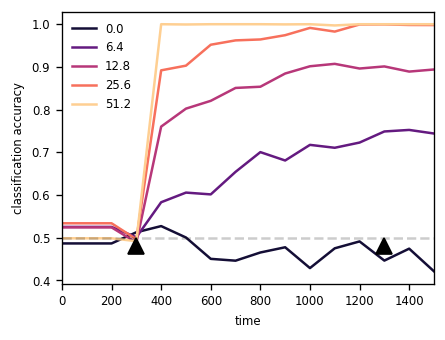

In [140]:
# colors corresponding to different values of color gradient
colors = plt.get_cmap('magma')(np.linspace(0.1,.9, len(np.unique(info.coh.values))))

# plot linear classification accuracy
plt.figure(figsize=(4,3), dpi=120)

# plot mean acc for each coherence level
for ci in range(len(np.unique(info.coh.values))):
    plt.plot(t_plot, np.mean(mean_acc[ci], axis=0), color=colors[ci], label=np.unique(info.coh.values)[ci])

plt.plot(t_plot, np.zeros(mean_acc[ci].shape[1])+.5, 'k--', alpha=.2)    
plt.plot(stim_onset, .48, '^', color = 'k', ms=10)
plt.plot(resp_onset, .48, '^', color='k', ms=10)
plt.ylabel('classification accuracy')
plt.xlabel('time')
plt.xlim(t_plot[0], t_plot[-1])
plt.legend(frameon=False)